# Simple MNIST Neural Net from scratch
Here we implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

/Users/BenRombaut/opt/anaconda3/envs/nn_from_scratch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Get the dataset

Once you download and save the dataset, you can just reload them using the commented code

In [2]:
mnist = fetch_openml("mnist_784", version=1)
mnist['data'].to_csv('./mnist_data.csv')
mnist['target'].to_csv('./mnist_target.csv')
mnist.keys()

# mnist = dict()
# mnist['data'] = pd.read_csv('./mnist_data.csv', index_col=0)
# mnist['target'] = pd.read_csv('./mnist_target.csv', index_col=0).squeeze('columns')

Preprocess the data so it's in a format we want (Numpy arrays) and shuffle into dev and train sets

In [3]:
data, target = mnist["data"].to_numpy(), mnist["target"].to_numpy()
target = target.astype(np.uint8)
data = np.c_[target, data]
data = data.astype(np.uint8)

m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

print(Y_train)
print(X_train[:, 0].shape)

[8 1 9 ... 8 3 9]
(784,)


Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [4]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    # If Z > 0, return 1, which is the slope of the line.
    # Else return 0 (which is still the slope, but recall that values less than 0 are 0)
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    # m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descnet(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print(f"Iteration: {i}")
            predictions = get_predictions(A2)
            print(f"Accuracy: {get_accuracy(predictions, Y)}")
    return W1, b1, W2, b2

In [7]:
W1, b1, W2, b2 = gradient_descnet(X_train, Y_train, 500, 0.1)

Iteration: 0
[5 1 8 ... 1 1 8] [8 1 9 ... 8 3 9]
Accuracy: 0.10685507246376812
Iteration: 50
[4 1 9 ... 1 3 7] [8 1 9 ... 8 3 9]
Accuracy: 0.4947536231884058
Iteration: 100
[4 1 9 ... 1 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.6599855072463768
Iteration: 150
[8 1 9 ... 1 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.7343188405797102
Iteration: 200
[8 1 9 ... 3 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.7734927536231884
Iteration: 250
[8 3 9 ... 8 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.7977826086956522
Iteration: 300
[8 3 9 ... 8 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.8144492753623188
Iteration: 350
[8 8 9 ... 8 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.8259565217391305
Iteration: 400
[8 8 9 ... 8 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.8347536231884058
Iteration: 450
[8 1 9 ... 8 3 9] [8 1 9 ... 8 3 9]
Accuracy: 0.8427101449275363


~85% accuracy on training set

In [8]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [8]
Label:  8


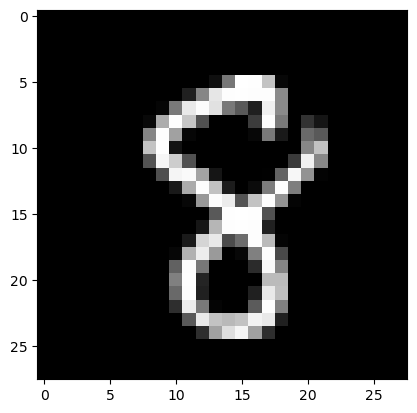

Prediction:  [1]
Label:  1


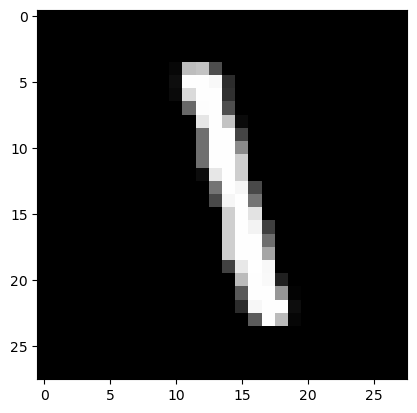

Prediction:  [9]
Label:  9


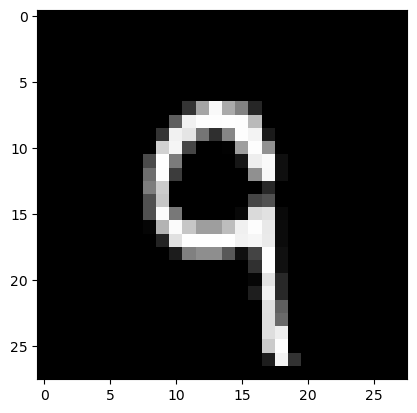

Prediction:  [1]
Label:  1


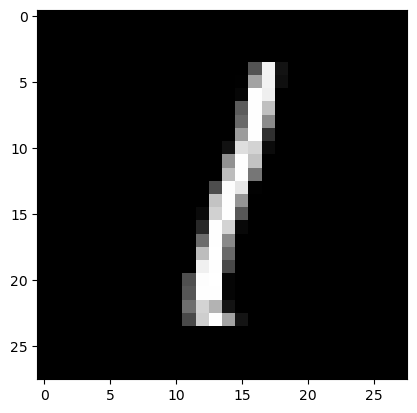

In [9]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [10]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[7 3 1 4 8 6 6 2 4 4 8 7 9 4 5 2 8 1 2 1 9 3 5 2 1 1 0 7 0 9 9 8 8 2 1 5 4
 3 1 7 9 2 6 7 4 6 1 6 6 3 0 7 5 0 5 7 1 8 8 5 8 3 6 5 5 7 3 6 6 2 1 5 5 4
 6 9 1 8 1 3 7 6 5 9 9 6 1 9 0 4 7 4 9 1 3 5 8 8 0 7 5 7 1 9 4 5 7 6 1 8 4
 5 0 3 1 6 1 6 3 4 4 0 7 6 1 1 3 5 8 7 3 6 2 0 0 6 1 8 4 3 4 4 4 2 0 0 0 8
 5 4 6 0 6 5 7 7 4 4 3 4 1 3 4 7 9 3 1 7 5 7 5 4 6 1 6 9 7 6 2 2 2 8 1 3 3
 6 3 7 5 6 7 8 2 7 9 5 3 2 2 5 6 9 9 6 1 2 8 8 4 0 0 5 9 8 9 1 3 1 1 5 0 2
 7 2 3 8 6 9 2 1 0 6 0 0 6 0 2 8 1 1 4 7 4 4 9 1 4 2 0 4 4 1 0 3 8 3 5 0 5
 4 1 3 7 9 5 1 3 7 5 0 2 3 5 6 5 7 9 5 3 8 5 8 8 8 9 3 6 3 4 4 4 4 6 5 6 4
 9 1 5 1 1 1 6 9 0 4 4 1 3 6 5 3 1 1 6 0 4 4 1 4 0 1 9 6 3 6 9 4 9 9 3 3 3
 7 4 9 1 7 8 9 5 5 1 8 1 8 1 3 4 1 2 7 5 9 0 3 8 5 0 1 1 1 5 0 0 1 0 2 5 0
 4 4 1 7 8 4 5 7 5 3 3 3 2 5 6 4 3 8 0 9 3 6 8 6 1 3 6 9 0 8 3 8 3 2 0 2 8
 1 0 2 8 8 1 0 0 3 7 1 3 8 1 4 6 4 1 4 0 2 3 7 1 1 8 7 5 8 1 8 3 4 6 5 0 4
 9 0 0 6 1 3 2 5 3 9 7 9 5 9 7 8 5 9 5 3 9 8 6 1 2 9 8 9 5 5 2 9 1 7 2 1 4
 3 9 7 1 0 9 3 2 0 7 5 4 

0.833

Still 83% accuracy, so our model generalized from the training data pretty well.